# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [87]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
print('ok')

ok


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [88]:
# TODO - your code here
# Use what we did live in lecture as an example
#pandas numpy matplotlib seaborn scikit-learn
#testing animation with random data
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
line, = ax.plot(np.random.rand(10))
ax.set_ylim(0, 1)


def update(data):
    line.set_ydata(data)
    return line,


def data_gen():
    while True:
        yield np.random.rand(10)

ani = animation.FuncAnimation(fig, update, data_gen, interval=100)

plt.close()
HTML(ani.to_html5_video())


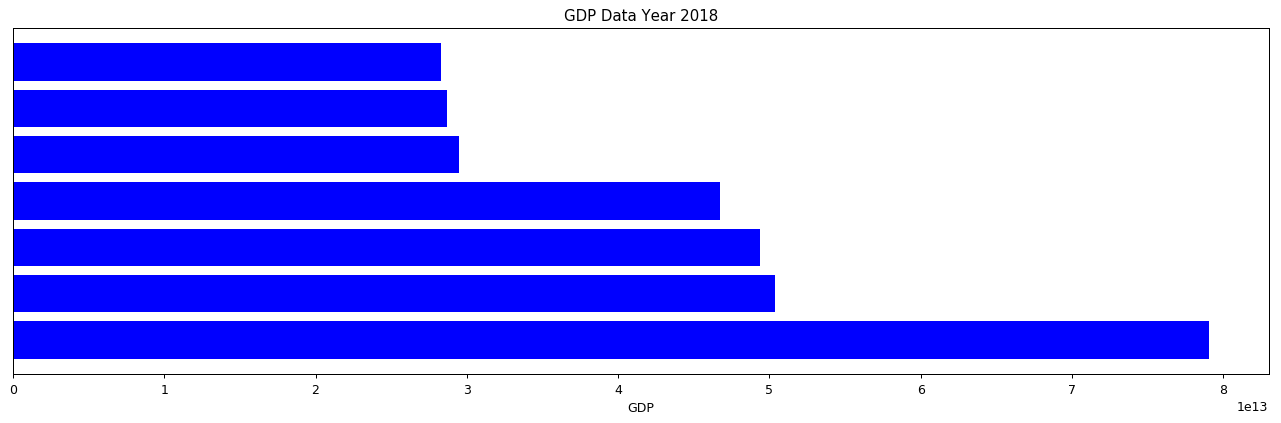

In [109]:
#testing with real data from https://github.com/datasets/gdp/
import pandas
df = pandas.read_csv('https://github.com/datasets/gdp/raw/master/data/gdp.csv')

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(18, 5), dpi= 90, facecolor='w', edgecolor='k')

plt.xlabel('GDP in USD')

def animate(i):
  df2= df[df['Year'] == 1968+i]
  df2 = df2.sort_values(by=['Value'],ascending=False)
  objects = df2['Country Name'][:7]
  y_pos = np.arange(len(objects))
  performance = df2['Value'][:7]
  plt.barh(y_pos, performance, align='center', color='#0000ff')

  plt.yticks(y_pos, objects)
 
  plt.title('GDP Data Year {}'.format(1968+i))
  return (fig,)

anim2 = animation.FuncAnimation(fig, animate,
                               frames=51, interval=1000, blit=True)

HTML(anim2.to_html5_video())


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

  **It's a bar graph of GDP of the top regions/groups/countries since 1968**

2.  What was the most challenging part of what you did?

  **Reading and understanding the documentations of matplotlib and Ipython to figure out a way to display the the charts the way that I want.**

3.  What was the most interesting thing you learned?
  ***Animation can really help in making more intuitive graphs***

4.  What area would you like to explore with more time?

  **Read more the documentation of matplotlib and make some 3d chart animations**



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.